<a href="https://colab.research.google.com/github/yusuku/DepthEstimationFrom360/blob/main/Midas2Onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/isl-org/MiDaS.git
%cd MiDaS
!pip install torch torchvision
!pip install timm
!pip install einops
!pip install onnx


Cloning into 'MiDaS'...
remote: Enumerating objects: 622, done.
remote: Counting objects: 100% (247/247), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 622 (delta 183), reused 139 (delta 137), pack-reused 375 (from 1)
Receiving objects: 100% (622/622), 3.44 MiB | 13.81 MiB/s, done.
Resolving deltas: 100% (246/246), done.
/content/MiDaS
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 51.9 MB/s eta 0:00:00


In [2]:
import cv2
import torch
import utils
from midas.dpt_depth import DPTDepthModel
from midas.midas_net_custom import MidasNet_small
from midas.midas_net import MidasNet
import os
import requests
import gc

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
def download_file(url, folder_path):
    # Create the folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)

    # Get the file name from the URL
    file_name = url.split("/")[-1]

    # Combine the folder path and file name to get the full file path
    file_path = os.path.join(folder_path, file_name)

    # Check if the file already exists in the folder
    if os.path.exists(file_path):
        print(f"File already downloaded: {file_path}")
    else:
        # Send an HTTP GET request to the URL
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Open the file and write the content from the response
            with open(file_path, 'wb') as file:
                file.write(response.content)
            print(f"File downloaded and saved to: {file_path}")
        else:
            print(f"Failed to download the file. HTTP status code: {response.status_code}")

In [5]:
import torch.nn.functional as F

# Custom normalization layer
class NormalizationLayer(torch.nn.Module):
    def __init__(self, mean, std):
        super(NormalizationLayer, self).__init__()
        self.mean = mean.view(1, -1, 1, 1)
        self.std = std.view(1, -1, 1, 1)

    def forward(self, x):
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return (x - self.mean) / self.std


class StandardizationLayer(torch.nn.Module):
    def __init__(self):
        super(StandardizationLayer, self).__init__()

    def forward(self, x):
        # Use torch.min and torch.max instead of torch(x).min and torch(x).max
        x = x.unsqueeze(1)
        x = F.interpolate(x, size=(512, 1024), mode='bilinear', align_corners=False)
        # 他の処理
        return (x - torch.min(x)) / (torch.max(x) - torch.min(x))
# convert all models

url="https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt"
onnxFile = "weights/" +" midas_v21_small_256" + ".onnx"
download_file(url, "weights")


model_path = "weights/midas_v21_small_256.pt"
device = torch.device("cpu")


model = MidasNet_small(
    model_path,
    features=64,
    backbone="efficientnet_lite3",
    exportable=True,
    non_negative=True,
    blocks={'expand': True}
)


# specify input size

net_w, net_h = 256, 256



mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# insert normalization layer at the beginning of the model
norm_layer = NormalizationLayer(mean, std)
stn_layer=StandardizationLayer()
model = torch.nn.Sequential(norm_layer,model,stn_layer)#, model,stn_layer)


model.eval()



File already downloaded: weights/midas_v21_small_256.pt
Loading weights:  weights/midas_v21_small_256.pt


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Sequential(
  (0): NormalizationLayer()
  (1): MidasNet_small(
    (pretrained): Module(
      (layer1): Sequential(
        (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act1): ReLU6(inplace=True)
            (se): Identity()
            (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act2): Identity()
          )
        )
        (4): Sequential(
          (0): InvertedResidual(
            (conv_pw): Conv2d(24, 

In [6]:
output=model(torch.rand(1, 3, 512, 1024, dtype=torch.float))
output.shape

torch.Size([1, 1, 512, 1024])

In [16]:
# 1. 画像を読み込む
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

image_path ="/content/f98f146eba5a102cb3441b0963f3c57e (1).png" # 画像のパスを指定
image = Image.open(image_path).convert('RGB')  # RGB形式に変換

# 2. リサイズとTensor変換を定義
transform = transforms.Compose([
    transforms.Resize((512, 1024)),  # 高さ512, 幅1024にリサイズ
    transforms.ToTensor()  # [0, 255] → [0.0, 1.0]に正規化
]) # [0, 255] → [0.0, 1.0]に正規化 & CHW形式に変換

# 3. 画像をTensorに変換
image_tensor = transform(image)

# 4. 次元を(1, 512, 1024)に変形
image_tensor = image_tensor.unsqueeze(0)

outputs= model(image_tensor)

image_to_display=outputs.squeeze()

In [17]:
image_to_display.shape

torch.Size([512, 1024])

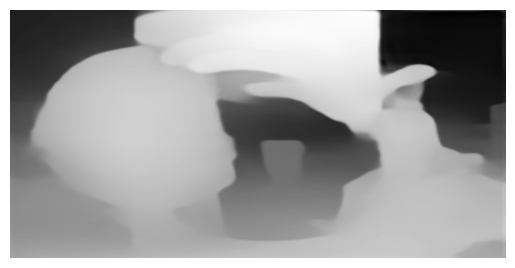

In [18]:
plt.imshow(image_to_display.detach().numpy(), cmap='gray') # Detach the tensor before converting to numpy
plt.axis('off')  # 軸を非表示
plt.show()

In [ ]:
torch.onnx.export(
    model,
    torch.rand(1, 3, 512, 1024, dtype=torch.float),
    onnxFile,
    export_params=True,
    opset_version=15,
    input_names=["input_image"],
    output_names=["output_depth"],
    do_constant_folding=True
)

# free memory
del model
gc.collect()

70